In [ ]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde
from shapely.geometry import Point, Polygon
import alphashape
from scipy.spatial.distance import cdist
import pyproj
from shapely.ops import transform
from functools import partial
import math
from pathlib import Path
from rasterio.transform import xy  # Import the xy function

def generate_volume_density_map(df, city_name, year, bw=None, output_dir="density_maps"):
    """Volume density map function with city and year information"""
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Verify DataFrame has data
    if df.empty:
        print("[ERROR] Cannot generate density map - empty DataFrame")
        return
    
    # Verify enough data points
    if len(df) < 2:
        print("[ERROR] Insufficient data points for kernel density estimation")
        return
    
    print("[DEBUG] Computing volume kernel density")
    
    try:
        # Use logarithmic scaling for better visualization
        log_volumes = np.log1p(df['building_volume'])
        
        # Kernel density estimation
        print(f"[DEBUG] Preparing density estimation")
        print(f"  Volume data points: {len(df)}")
        print(f"  Log volumes shape: {log_volumes.shape}")
        
        # Use 2D coordinates for density estimation
        coords = df[['longitude', 'latitude']].values
        
        print(f"[DEBUG] Coordinates shape: {coords.shape}")
        
        # Create grid for density map
        x_grid, y_grid = np.meshgrid(
            np.linspace(df['longitude'].min(), df['longitude'].max(), 200),
            np.linspace(df['latitude'].min(), df['latitude'].max(), 200)
        )
        
        # Kernel density estimation with R-style bandwidth if provided
        if bw is not None:
            print(f"[DEBUG] Using R-style bandwidth: {bw} for KDE")
            # Use Scott's rule to adjust bandwidth
            scott_factor = len(coords)**(-1/6)
            # Convert geographical bandwidth to KDE bandwidth parameter
            kde_bandwidth = bw * scott_factor
            kde = gaussian_kde(coords.T, weights=log_volumes, bw_method=kde_bandwidth)
        else:
            # Use default bandwidth
            kde = gaussian_kde(coords.T, weights=log_volumes)
        
        # Compute density
        grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
        density_values = kde(grid_coords).reshape(x_grid.shape)
        
        # Store the KDE object for future use (like R's pcf.kern)
        kde_output_file = os.path.join(output_dir, f"{city_name}_{year}_kde.pkl")
        with open(kde_output_file, 'wb') as f:
            pickle.dump(kde, f)
        print(f"[DEBUG] KDE object saved to: {kde_output_file}")
        
        # Plot density map with contours
        plt.figure(figsize=(12, 10))
        
        # Plot density as a heat map
        im = plt.imshow(density_values, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()], 
                   origin='lower', cmap='viridis', alpha=0.7)
        
        # Add contours
        contours = plt.contour(x_grid, y_grid, density_values, 
                              levels=10, colors='white', alpha=0.8, linewidths=0.5)
        plt.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
        
        plt.colorbar(im, label='Log Volume Density')
        plt.title(f'Building Volume Density Map - {city_name} {year}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        
        # Save figure
        output_file = os.path.join(output_dir, f"{city_name}_{year}_volume_density_map.png")
        plt.savefig(output_file)
        plt.close()
        
        print(f"[DEBUG] Volume density map generated successfully: {output_file}")
    
    except Exception as e:
        print(f"[ERROR] Volume density map generation failed: {e}")
        import traceback
        traceback.print_exc()

Estimated GPU memory needed: 4.45 GB
[DEBUG] Computing volume kernel density
[DEBUG] Using latitude-adjusted bandwidth: 0.003171 (base_bw=0.003, mean_lat=-18.8968075811821)
[DEBUG] Coordinates shape: (1449064, 2)
[DEBUG] Grid resolution: 200x200
[DEBUG] Using GPU acceleration with CuPy
[DEBUG] Processing grid in 7x7 tiles with 10 pixel overlap
[DEBUG] Completed tile (1/7, 1/7)
[DEBUG] Completed tile (1/7, 2/7)
[DEBUG] Completed tile (1/7, 3/7)
[DEBUG] Completed tile (1/7, 4/7)
[DEBUG] Completed tile (1/7, 5/7)
[DEBUG] Completed tile (1/7, 6/7)
[DEBUG] Completed tile (1/7, 7/7)
[DEBUG] Completed tile (2/7, 1/7)
[DEBUG] Completed tile (2/7, 2/7)
[DEBUG] Completed tile (2/7, 3/7)
[DEBUG] Completed tile (2/7, 4/7)
[DEBUG] Completed tile (2/7, 5/7)
[DEBUG] Completed tile (2/7, 6/7)
[DEBUG] Completed tile (2/7, 7/7)
[DEBUG] Completed tile (3/7, 1/7)
[DEBUG] Completed tile (3/7, 2/7)
[DEBUG] Completed tile (3/7, 3/7)
[DEBUG] Completed tile (3/7, 4/7)
[DEBUG] Completed tile (3/7, 5/7)
[DEBUG] 

Traceback (most recent call last):
  File "/tmp/ipykernel_5741/1409594232.py", line 343, in generate_smooth_density_map
    contour_levels = measure.find_contours(density_values, np.linspace(0, density_values.max()*0.95, 10))
  File "/home/liang/anaconda3/envs/ug-env/lib/python3.13/site-packages/skimage/measure/_find_contours.py", line 147, in find_contours
    image.astype(np.float64), float(level), fully_connected == 'high', mask=mask
                              ~~~~~^^^^^^^
TypeError: only length-1 arrays can be converted to Python scalars


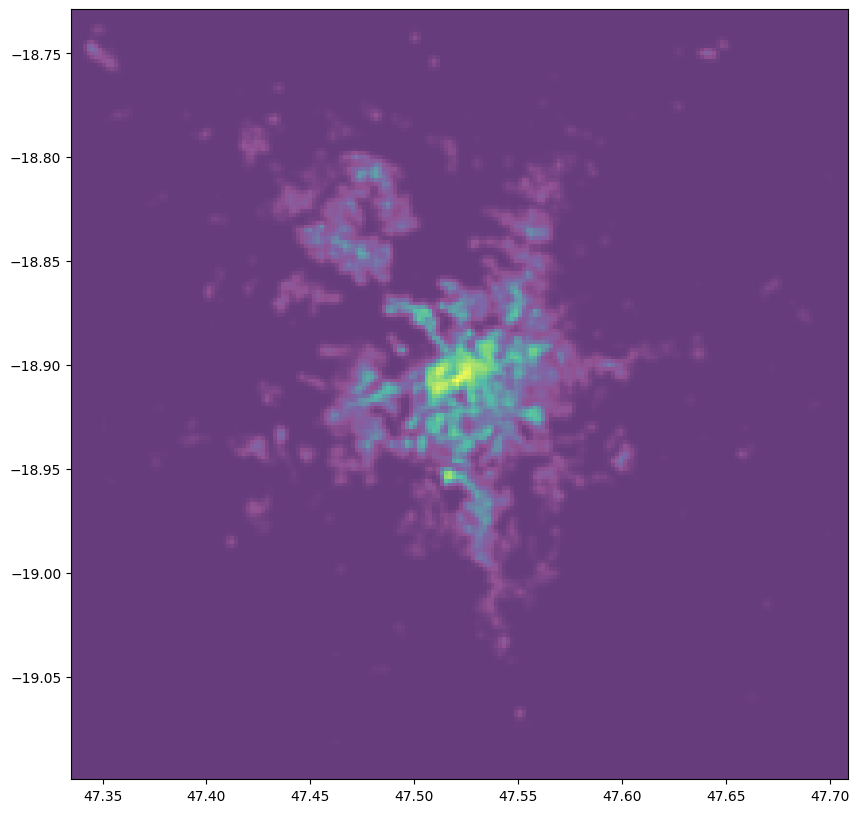

In [10]:
# Load your dataset
df = pd.read_csv("pixel_data/Antananarivo_2016_pixel_data.csv")

# First, check approximate memory requirements
mem_estimate = estimate_gpu_memory_requirements(
    n_data_points=len(df),
    grid_resolution=100,  # Try a smaller grid
    tile_size=20          # Use small tiles
)
print(f"Estimated GPU memory needed: {mem_estimate['total_memory_gb']:.2f} GB")

# # If needed, adjust parameters based on the estimate
# test_bandwidth_values(
#     df, 
#     city_name='Amsterdam', 
#     year=2022, 
#     bw_values=[0.001, 0.002, 0.003], 
#     use_gpu=True,
#     grid_resolution=100,  # Lower resolution grid
#     tile_size=20,         # Small tiles for low memory usage
#     max_points_per_batch=500  # Smaller batches
# )

# # Or use specific bandwidth with even more conservative memory settings
# generate_smooth_density_map(
#     df, 
#     city_name='Antananarivo', 
#     year=2016, 
#     base_bw=0.01, 
#     use_gpu=True,
#     grid_resolution=80,   # Even lower resolution if needed
#     tile_size=10,         # Very small tiles
#     max_points_per_batch=250  # Very small batches
# )


generate_smooth_density_map(
    df, 
    city_name='Antananarivo', 
    year = 2016, 
    base_bw=0.003, 
    use_gpu=True, 
    output_dir="density_maps",
    grid_resolution=200,
    tile_size=50,
    overlap=10, 
    smooth_sigma=0.8,
    use_float64=True)

In [10]:
df = pd.read_csv("pixel_data/Abidjan_2016_pixel_data.csv")
generate_volume_density_map(df, "Abidjan", 2016, bw=None, output_dir="density_maps")

[DEBUG] Computing volume kernel density
[DEBUG] Preparing density estimation
  Volume data points: 2681355
  Log volumes shape: (2681355,)
[DEBUG] Coordinates shape: (2681355, 2)
[DEBUG] KDE object saved to: density_maps/Abidjan_2016_kde.pkl
[DEBUG] Volume density map generated successfully: density_maps/Abidjan_2016_volume_density_map.png


## New - Raster to Contour

In [20]:
import rasterio
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
from tqdm.notebook import tqdm
import logging
import ipywidgets as widgets
from IPython.display import display

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('terrain_analyzer')

class TerrainAnalyzer:
    """
    Interactive terrain analyzer for processing DEM data, extracting contours, 
    and building hierarchical contour trees.
    """
    
    def __init__(self):
        """Initialize analyzer with default parameters"""
        self.height = None         # Height data from DEM
        self.conf = None           # Confidence data (if available)
        self.metadata = None       # Geospatial metadata
        self.base_data = None      # Current data being analyzed (height, volume, or area)
        self.data_smooth = None    # Smoothed version of base data
        self.contour_tree = None   # NetworkX graph of contour relationships
        self.contour_levels = None # Values of contour levels
        self.contours_by_level = {}  # Dict of contours organized by level
        # self.analysis_mode = 'volume'  # Current analysis mode (volume, height, area)
    
    def load_tiff(self, tiff_path, band_height=2, band_conf=3):
        """
        Load height and confidence bands from a TIFF file
        
        Args:
            tiff_path: Path to TIFF file
            band_height: Band index for height data
            band_conf: Band index for confidence data
        
        Returns:
            bool: Success or failure
        """
        logger.info(f"Loading TIFF data from {tiff_path}")
        try:
            with rasterio.open(tiff_path) as src:
                self.height = src.read(band_height).astype(np.float32)
                self.conf = src.read(band_conf).astype(np.float32)
                self.metadata = {
                    'transform': src.transform,
                    'crs': src.crs,
                    'bounds': src.bounds,
                    'shape': self.height.shape
                }
                logger.info(f"Data loaded successfully. Shape: {self.height.shape}")
            return True
        except Exception as e:
            logger.error(f"Error loading TIFF file: {e}")
            return False
    
    def process_data(self, conf_threshold=0.5, smooth=True, sigma=3):
        """
        Process data
        
        Args:
            # mode: Analysis mode ('volume', 'height', or 'area')
            conf_threshold: Minimum confidence value to consider valid
            smooth: Whether to apply smoothing
            sigma: Smoothing factor for Gaussian filter
            
        Returns:
            bool: Success or failure
        """
        if self.height is None or self.conf is None:
            logger.error("No data loaded. Call load_tiff first.")
            return False
            
        logger.info(f"Processing Volume data with confidence threshold: {conf_threshold}")
        # self.analysis_mode = mode
        
        # Create mask from confidence data
        mask = (self.conf > conf_threshold)
        
        self.base_data = np.where(mask, self.height, 0)
        
        # Apply smoothing if requested
        if smooth:
            logger.info(f"Applying Gaussian smoothing with sigma={sigma}")
            self.data_smooth = gaussian_filter(self.base_data, sigma=sigma)
        else:
            self.data_smooth = self.base_data.copy()
            
        return True
    
    def extract_contours(self, levels=None, min_points=5, min_area=10):
        """
        Extract and filter contours from smoothed data
        
        Args:
            levels: list of specific values
            min_points: Minimum number of points to keep a contour
            min_area: Minimum area to keep a contour
            
        Returns:
            bool: Success or failure
        """
        from skimage.measure import find_contours
        
        if self.data_smooth is None:
            logger.error("No processed data available. Run process_data first.")
            return False
        
        # Calculate contour levels
        # if isinstance(levels, int):
        #     # Include zero in the range if requested
        #     vmin = np.min(self.data_smooth)
        #     vmax = np.max(self.data_smooth)
        #     level_values = np.linspace(vmin, vmax, levels)
        # else:
        #     level_values = np.array(levels)
        
        if levels is None:
            levels = np.arange(0, 7.5, 0.5).tolist()
        
        level_values = np.array(levels)
        self.contour_levels = level_values
        logger.info(f"Extracting contours at {len(level_values)} levels from {level_values[0]:.2f} to {level_values[-1]:.2f}")
        
        # Clear previous contours
        self.contours_by_level = {}
        
        # Extract contours for each level
        for i, level in enumerate(tqdm(level_values, desc="Extracting contours")):
            # Find raw contours at this level
            raw_contours = find_contours(self.data_smooth, level=level)
            
            # Process and filter contours
            processed_contours = []
            
            for j, contour in enumerate(raw_contours):
                # Skip very small contours
                if len(contour) < min_points:
                    continue
                
                # Create a polygon for area calculation
                try:
                    poly = Polygon(contour[:, ::-1])  # swap x, y for Shapely
                    
                    # Skip invalid or tiny polygons
                    if not poly.is_valid or poly.is_empty or poly.area < min_area:
                        continue
                    
                    # Store contour data
                    contour_info = {
                        'contour': contour,
                        'level': level,
                        'level_idx': i,
                        'area': poly.area,
                        'perimeter': poly.length,
                        'polygon': poly,
                        'centroid': (poly.centroid.x, poly.centroid.y),
                        'contour_id': f"{i}_{j}"
                    }
                    
                    processed_contours.append(contour_info)
                    
                except Exception as e:
                    logger.debug(f"Error processing contour: {e}")
                    continue
            
            # Store processed contours for this level
            self.contours_by_level[i] = processed_contours
            logger.info(f"Level {i+1}: Kept {len(processed_contours)} significant contours")
        
        total_contours = sum(len(contours) for contours in self.contours_by_level.values())
        logger.info(f"Extracted {total_contours} total significant contours across all levels")
        
        return True
    
    def build_contour_tree(self):
        """
        Build hierarchical contour tree based on containment relationships
        between contours at different levels. Higher value contours are contained
        within lower value contours.
        
        Returns:
            bool: Success or failure
        """
        if not self.contours_by_level:
            logger.error("No contours extracted. Call extract_contours first.")
            return False
        
        logger.info("Building contour tree based on containment relationships")
        
        # Create contour tree graph
        G = nx.DiGraph()
        
        # Add nodes to the graph
        node_lookup = {}  # Map from contour_id to node in graph
        
        # First pass: Add all contours as nodes
        for level_idx, contours in self.contours_by_level.items():
            level_value = self.contour_levels[level_idx]
            for contour_info in contours:
                # Create node with contour data
                node_id = contour_info['contour_id']
                G.add_node(node_id, **contour_info)
                node_lookup[node_id] = node_id
        
        # Sort level indices in descending order (process from highest to lowest level)
        level_indices = sorted(self.contours_by_level.keys(), reverse=True)
        
        # Build parent-child relationships based on polygon containment
        for i, high_level_idx in enumerate(level_indices):
            high_contours = self.contours_by_level[high_level_idx]
            
            # Skip if no contours at this level
            if not high_contours:
                continue
                
            # For each contour at higher level
            for high_contour in tqdm(high_contours, desc=f"Processing level {high_level_idx}"):
                high_poly = high_contour['polygon']
                high_node = high_contour['contour_id']
                
                # Find lowest level that contains this contour
                for j in range(i + 1, len(level_indices)):
                    low_level_idx = level_indices[j]
                    low_contours = self.contours_by_level[low_level_idx]
                    
                    for low_contour in low_contours:
                        low_poly = low_contour['polygon']
                        low_node = low_contour['contour_id']
                        
                        # Check containment (high value contour is contained in low value contour)
                        if low_poly.contains(high_poly):
                            G.add_edge(low_node, high_node)
                            # Once we find a parent, stop looking at lower levels
                            break
                    
                    # If we found at least one parent at this level, stop looking at lower levels
                    if any(G.predecessors(high_node)):
                        break
        
        # Remove redundant edges for cleaner hierarchy
        # (If A->B->C, remove A->C direct edge)
        redundant_edges = []
        for node in G.nodes():
            descendants = nx.descendants(G, node)
            for successor in list(G.successors(node)):
                # Check if there's an indirect path
                for other_successor in list(G.successors(node)):
                    if other_successor != successor and successor in nx.descendants(G, other_successor):
                        redundant_edges.append((node, successor))
                        break
        
        # Remove redundant edges
        for source, target in redundant_edges:
            G.remove_edge(source, target)
        
        self.contour_tree = G
        logger.info(f"Built contour tree with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        
        return True

    def create_contour_map(self, figsize=(12, 8), levels=None, cmap='viridis',
                         contour_colors='white', add_labels=True, 
                         output_path=None, include_zeros=True):
        """
        Create contour map visualization with geographic coordinates
        
        Args:
            figsize: Figure size
            levels: Contour levels (int for count or list for specific values)
            cmap: Colormap name
            contour_colors: Line color for contours
            add_labels: Whether to add contour labels
            output_path: Path to save output image
            include_zeros: Whether to include zero values in color scale
            
        Returns:
            bool: Success or failure
        """
        if self.data_smooth is None:
            logger.error("No processed data available. Run process_data first.")
            return False
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Prepare data for plotting
        plot_data = self.data_smooth.copy()
        
        # Handle background treatment based on include_zeros parameter
        if not include_zeros:
            # Make zeros NaN for transparent background
            background_mask = plot_data < 0.001
            plot_data[background_mask] = np.nan
        
        vmin, vmax = np.nanmin(plot_data), np.nanmax(plot_data)
        
        # Use specified levels or calculate
        if levels is None:
            levels = self.contour_levels if self.contour_levels is not None else 15
            
        if isinstance(levels, int):
            level_values = np.linspace(vmin, vmax, levels)
        else:
            level_values = levels
        
        # Create masked array for plotting
        masked_data = np.ma.masked_invalid(plot_data)
        
        # Use geographic coordinates if available
        height, width = masked_data.shape
        
        if self.metadata and 'transform' in self.metadata:
            # Transform from pixel to projection coordinates
            transform = self.metadata['transform']
            
            # Create coordinate grids
            rows, cols = np.mgrid[0:height, 0:width]
            xs, ys = transform * (cols, rows)
            
            # Create contour plot with geographic coordinates
            contourf = ax.contourf(xs, ys, masked_data, levels=level_values, cmap=cmap,
                                 extend='both', alpha=0.8)
            
            contour = ax.contour(xs, ys, masked_data, levels=level_values,
                               colors=contour_colors, linewidths=0.8)
            
            # Set axis labels based on CRS
            if self.metadata.get('crs') and self.metadata['crs'].to_epsg() == 4326:  # WGS84
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
            else:
                ax.set_xlabel('Easting')
                ax.set_ylabel('Northing')
        else:
            # Use pixel coordinates if no geospatial metadata
            contourf = ax.contourf(masked_data, levels=level_values, cmap=cmap,
                                 extend='both', alpha=0.8)
            
            contour = ax.contour(masked_data, levels=level_values,
                               colors=contour_colors, linewidths=0.8)
            ax.set_xlabel('X (pixels)')
            ax.set_ylabel('Y (pixels)')
        
        # Add contour labels if requested
        if add_labels:
            fmt = {level: f'{level:.2f}' for level in contour.levels}
            ax.clabel(contour, contour.levels[::2], inline=True, fmt=fmt, fontsize=8)
        
        # Add colorbar
        cbar = fig.colorbar(contourf)
        # cbar.set_label(f'{self.analysis_mode.title()} Value')
        cbar.set_label('Volume Value')
        
        # plt.title(f'{self.analysis_mode.title()} Map with Contour Lines')
        plt.title('Volume Map with Contour Lines')
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        return True
    
    def visualize_contour_tree(self, figsize=(20, 10), node_size=200, font_size=12, 
                             output_path=None, levels = None):
        """
        Visualize contour tree with consistently sized nodes and numbered labels (C1, C2, etc.)
        
        Args:
            figsize: Figure size
            node_size: Size of nodes (uniform)
            font_size: Size of labels
            output_path: Path to save output image
            
        Returns:
            bool: Success or failure
        """
        if self.contour_tree is None:
            logger.error("No contour tree available. Run build_contour_tree first.")
            return False

        if levels is None:
            levels = np.arange(0, 7.5, 0.5).tolist()

        
        # Create a copy of the graph
        G = self.contour_tree.copy()
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Group nodes by their level_idx
        nodes_by_level = {}
        for node, data in G.nodes(data=True):
            level = data.get('level', 0)
            if level not in nodes_by_level:
                nodes_by_level[level] = []
            nodes_by_level[level].append(node)
        
        # Create a hierarchical layout
        pos = {}
        level_values = sorted(nodes_by_level.keys())
        
        # Calculate vertical position based on level value (y-axis)
        # y_min, y_max = min(level_values), max(level_values)
        # y_range = y_max - y_min
        y_min, y_max = min(levels), max(levels)
        y_range = y_max - y_min
        
        # Position nodes horizontally within each level
        for level in level_values:
            nodes = nodes_by_level[level]
            # Calculate y-position from level value (normalized)
            y_pos = (level - y_min) / (y_range or 1)
            
            # Layout nodes in a row
            x_step = 1.0 / (len(nodes) + 1)
            for i, node in enumerate(nodes):
                x_pos = (i + 1) * x_step
                pos[node] = (x_pos, y_pos)
        
        # Refine x-positions to align with parents/children
        for _ in range(2):  # Two passes should be enough
            for node in G.nodes():
                predecessors = list(G.predecessors(node))
                successors = list(G.successors(node))
                
                if predecessors:
                    # Average x position of parents
                    avg_x = sum(pos[p][0] for p in predecessors) / len(predecessors)
                    current_x, current_y = pos[node]
                    # Move partially toward parent average (weighted adjustment)
                    pos[node] = (0.7 * current_x + 0.3 * avg_x, current_y)
                
                if successors:
                    # Adjust child positions to be near parent
                    parent_x, parent_y = pos[node]
                    child_count = len(successors)
                    child_width = 0.2  # Width to spread children
                    
                    # Position children around parent
                    for i, child in enumerate(successors):
                        child_x = parent_x - child_width/2 + (i * child_width/max(1, child_count-1))
                        # Keep y position based on level
                        child_y = pos[child][1]
                        pos[child] = (child_x, child_y)
        
        # Create node colors based on level value
        node_colors = []
        for node in G.nodes():
            level = G.nodes[node].get('level', 0)
            # Normalize level value for color
            norm_level = (level - y_min) / (y_range or 1)
            node_colors.append(plt.cm.viridis(norm_level))
        
        # Create sequential node labels (C1, C2, etc.)
        labels = {}
        # Store mapping from original node IDs to C-labels for future reference
        self.node_id_mapping = {}
        for i, node in enumerate(G.nodes()):
            c_label = f"C{i+1}"
            labels[node] = c_label
            self.node_id_mapping[c_label] = node
        
        # Draw graph elements with uniform node sizes
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, 
                             alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.0, edge_color='gray', 
                             arrowstyle='->', arrowsize=10, ax=ax)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size, 
                              font_weight='bold', ax=ax)
        
        # Add colorbar with actual contour values
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=y_min, vmax=y_max))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label(f"Volume Value")
        ax.set_title("Contour Tree - Volulme Analysis")
        ax.axis('off')
        
        # Save if requested
        if output_path:
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
        
        plt.tight_layout()
        plt.show()
        
        # Print tree stats
        print(f"Contour tree: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        print(f"- Root nodes (no parent): {len([n for n in G.nodes() if G.in_degree(n)==0])}")
        print(f"- Leaf nodes (no children): {len([n for n in G.nodes() if G.out_degree(n)==0])}")
        print(f"- Branch nodes (multiple children): {len([n for n in G.nodes() if G.out_degree(n)>1])}")
        
        return True
    
    def get_node_information(self):
        """
        Get information about contour tree nodes including ID, value, and coordinates
        
        Returns:
            dict: Dictionary with node information
        """
        if self.contour_tree is None or not hasattr(self, 'node_id_mapping'):
            logger.error("No contour tree available or node mapping not created. Run visualize_contour_tree first.")
            return None
        
        node_info = {}
        
        for c_label, node_id in self.node_id_mapping.items():
            # Get node data from contour tree
            node_data = self.contour_tree.nodes[node_id]
            
            # Extract information
            info = {
                'node_id': node_id,
                'value': node_data.get('level', 0),
                'coordinates': node_data.get('centroid', (0, 0)),
                'area': node_data.get('area', 0),
                'perimeter': node_data.get('perimeter', 0)
            }
            
            # Convert coordinates to lat/lon if metadata available
            if self.metadata and 'transform' in self.metadata:
                # We need to convert from pixel coordinates to projected coordinates
                # The centroid from Shapely is in pixel coordinates (row, col)
                y, x = node_data.get('centroid', (0, 0))
                
                # Use the transform to convert to projected coordinates
                transform = self.metadata['transform']
                lon, lat = transform * (x, y)
                
                # Add the geographical coordinates
                if self.metadata.get('crs') and self.metadata['crs'].to_epsg() == 4326:
                    # If we're using WGS84, these are directly lat/lon
                    info['lat_lon'] = (lat, lon)  # Format as (latitude, longitude)
                else:
                    # Otherwise they're in the projected CRS
                    info['projected_coords'] = (lon, lat)
            
            node_info[c_label] = info
        
        return node_info

    def compute_polycentrism(self, weight_by_level=True):
        """
        Compute the polycentrism index of the contour tree.
        
        Returns:
            float: Polycentrism index for the current city area.
        """
        if self.contour_tree is None:
            logger.error("No contour tree available. Run build_contour_tree first.")
            return None
        
        G = self.contour_tree
        
        # 找到根节点（没有父节点的）
        roots = [n for n in G.nodes if G.in_degree(n) == 0]
        
        branch_volumes = []
        for root in roots:
            branch_nodes = nx.descendants(G, root) | {root}
            if weight_by_level:
                V = sum(G.nodes[n]['area'] * G.nodes[n]['level'] for n in branch_nodes)
            else:
                V = sum(G.nodes[n]['area'] for n in branch_nodes)
            branch_volumes.append(V)
        
        if not branch_volumes:
            logger.warning("No valid branches found.")
            return None
        
        # 按体量降序
        V_sorted = sorted(branch_volumes, reverse=True)
        v1 = V_sorted[0]
        BRi = len(V_sorted)
        
        # 计算polycentrism
        poly_index = (1 / v1) * sum((k + 1) * V_sorted[k] for k in range(BRi))
        
        logger.info(f"Polycentrism index: {poly_index:.3f}")
        return poly_index

    
    def create_interactive_widgets(self):
        """
        Create interactive widgets for parameter adjustment and visualization
        
        Returns:
            widgets.Output: Output widget for displaying messages
        """
        # Define widgets
        # mode_dropdown = widgets.Dropdown(
        #     options=[('Volume', 'volume')],  # Removed height and area options
        #     value='volume',
        #     description='Analysis Mode:',
        #     style={'description_width': 'initial'}
        # )
        
        conf_threshold_slider = widgets.FloatSlider(
            value=0.5, min=0.1, max=0.9, step=0.05,
            description='Confidence Threshold:',
            style={'description_width': 'initial'}
        )
        
        sigma_slider = widgets.FloatSlider(
            value=3, min=1, max=10, step=0.5,
            description='Smoothing Sigma:',
            style={'description_width': 'initial'}
        )
        
        levels_slider = widgets.IntSlider(
            value=15, min=5, max=50, step=5,
            description='Contour Levels:',
            style={'description_width': 'initial'}
        )
        
        include_zeros_checkbox = widgets.Checkbox(
            value=True,
            description='Include Zero Values',
            style={'description_width': 'initial'}
        )
        
        min_points_slider = widgets.IntSlider(
            value=5, min=3, max=20, step=1,
            description='Min Points:',
            style={'description_width': 'initial'}
        )
        
        min_area_slider = widgets.IntSlider(
            value=10, min=1, max=100, step=5,
            description='Min Area:',
            style={'description_width': 'initial'}
        )
        
        visualization_dropdown = widgets.Dropdown(
            options=[
                ('Contour Map', 'contour'),
                ('Contour Tree', 'tree')
            ],
            value='contour',
            description='Visualization:',
            style={'description_width': 'initial'}
        )
        
        # Create buttons
        process_button = widgets.Button(
            description='Process Data',
            button_style='primary'
        )
        
        visualize_button = widgets.Button(
            description='Visualize',
            button_style='success'
        )
        
        node_info_button = widgets.Button(
            description='Get Node Info',
            button_style='info'
        )
        
        # Create output area for status messages
        output = widgets.Output()
        
        # Define button click handler for processing
        def on_process_button_click(b):
            with output:
                output.clear_output()
                # print(f"Processing {mode_dropdown.value} data...")
                print("Processing Volume data...")
                
                # Process data
                self.process_data(
                    # mode=mode_dropdown.value,
                    conf_threshold=conf_threshold_slider.value,
                    smooth=True,
                    sigma=sigma_slider.value
                )
                
                # Extract contours
                self.extract_contours(
                    levels=levels_slider.value,
                    min_points=min_points_slider.value,
                    min_area=min_area_slider.value
                )
                
                # Build contour tree
                self.build_contour_tree()
                
                print("Processing complete. Ready to visualize.")
        
        # Define button click handler for visualization
        def on_visualize_button_click(b):
            with output:
                output.clear_output()
                vis_type = visualization_dropdown.value
                print(f"Creating {vis_type} visualization...")
                
                try:
                    if vis_type == 'contour':
                        self.create_contour_map(
                            levels=levels_slider.value,
                            include_zeros=include_zeros_checkbox.value
                        )
                    elif vis_type == 'tree':
                        self.visualize_contour_tree()
                except Exception as e:
                    print(f"Error during visualization: {e}")
        
        # Define button click handler for node information
        def on_node_info_button_click(b):
            with output:
                output.clear_output()
                print("Retrieving node information...")
                
                try:
                    node_info = self.get_node_information()
                    if node_info:
                        # Display first few nodes as example
                        print("Node Information:")
                        for i, (c_label, info) in enumerate(node_info.items()):
                            print(f"{c_label}:")
                            print(f"  Value: {info['value']:.2f}")
                            print(f"  Coordinates: {info['coordinates']}")
                            if 'lat_lon' in info:
                                print(f"  Lat/Lon: {info['lat_lon']}")
                            print()
                            
                            # Only show first 5 nodes by default
                            if i >= 4:
                                print(f"... and {len(node_info) - 5} more nodes")
                                break
                        
                        # Show how to access full information
                        print("\nTo access full node information:")
                        print("node_info = terrain_analyzer.get_node_information()")
                    else:
                        print("No node information available. Run visualize_contour_tree first.")
                except Exception as e:
                    print(f"Error retrieving node information: {e}")
        
        # Connect buttons to handlers
        process_button.on_click(on_process_button_click)
        visualize_button.on_click(on_visualize_button_click)
        node_info_button.on_click(on_node_info_button_click)
        
        # Create widgets layout
        processing_panel = widgets.VBox([
            widgets.HTML("<h3>Data Processing</h3>"),
            # mode_dropdown,
            conf_threshold_slider,
            sigma_slider,
            levels_slider,
            min_points_slider,
            min_area_slider
        ])
        
        visualization_panel = widgets.VBox([
            widgets.HTML("<h3>Visualization</h3>"),
            visualization_dropdown,
            include_zeros_checkbox
        ])
        
        buttons_panel = widgets.HBox([process_button, visualize_button, node_info_button])
        
        # Display widgets
        display(widgets.VBox([
            widgets.HTML("<h2>Terrain Analyzer</h2>"),
            widgets.HBox([processing_panel, visualization_panel]),
            buttons_panel,
            widgets.HTML("<h3>Output</h3>"),
            output
        ]))
        
        return output

2025-10-24 17:03:38,054 - INFO - Loading TIFF data from /home/liang/Documents/Research/Urban_Growth/Python_Codes/images/Mexico City_2016.tif
2025-10-24 17:03:39,011 - INFO - Data loaded successfully. Shape: (4002, 4001)
2025-10-24 17:03:39,017 - INFO - Processing Volume data with confidence threshold: 0
2025-10-24 17:03:39,042 - INFO - Applying Gaussian smoothing with sigma=30
2025-10-24 17:03:40,880 - INFO - Extracting contours at 15 levels from 0.00 to 7.00


Extracting contours:   0%|          | 0/15 [00:00<?, ?it/s]

2025-10-24 17:03:40,997 - INFO - Level 1: Kept 5 significant contours
2025-10-24 17:03:41,188 - INFO - Level 2: Kept 26 significant contours
2025-10-24 17:03:41,378 - INFO - Level 3: Kept 37 significant contours
2025-10-24 17:03:41,533 - INFO - Level 4: Kept 53 significant contours
2025-10-24 17:03:41,710 - INFO - Level 5: Kept 68 significant contours
2025-10-24 17:03:41,894 - INFO - Level 6: Kept 69 significant contours
2025-10-24 17:03:42,222 - INFO - Level 7: Kept 55 significant contours
2025-10-24 17:03:42,504 - INFO - Level 8: Kept 67 significant contours
2025-10-24 17:03:42,760 - INFO - Level 9: Kept 60 significant contours
2025-10-24 17:03:42,913 - INFO - Level 10: Kept 42 significant contours
2025-10-24 17:03:43,035 - INFO - Level 11: Kept 18 significant contours
2025-10-24 17:03:43,157 - INFO - Level 12: Kept 18 significant contours
2025-10-24 17:03:43,280 - INFO - Level 13: Kept 17 significant contours
2025-10-24 17:03:43,393 - INFO - Level 14: Kept 13 significant contours
20

Processing level 14:   0%|          | 0/11 [00:00<?, ?it/s]

Processing level 13:   0%|          | 0/13 [00:00<?, ?it/s]

Processing level 12:   0%|          | 0/17 [00:00<?, ?it/s]

Processing level 11:   0%|          | 0/18 [00:00<?, ?it/s]

Processing level 10:   0%|          | 0/18 [00:00<?, ?it/s]

Processing level 9:   0%|          | 0/42 [00:00<?, ?it/s]

Processing level 8:   0%|          | 0/60 [00:00<?, ?it/s]

Processing level 7:   0%|          | 0/67 [00:00<?, ?it/s]

Processing level 6:   0%|          | 0/55 [00:00<?, ?it/s]

Processing level 5:   0%|          | 0/69 [00:00<?, ?it/s]

Processing level 4:   0%|          | 0/68 [00:00<?, ?it/s]

Processing level 3:   0%|          | 0/53 [00:00<?, ?it/s]

Processing level 2:   0%|          | 0/37 [00:00<?, ?it/s]

Processing level 1:   0%|          | 0/26 [00:00<?, ?it/s]

Processing level 0:   0%|          | 0/5 [00:00<?, ?it/s]

2025-10-24 17:03:43,993 - INFO - Built contour tree with 559 nodes and 259 edges


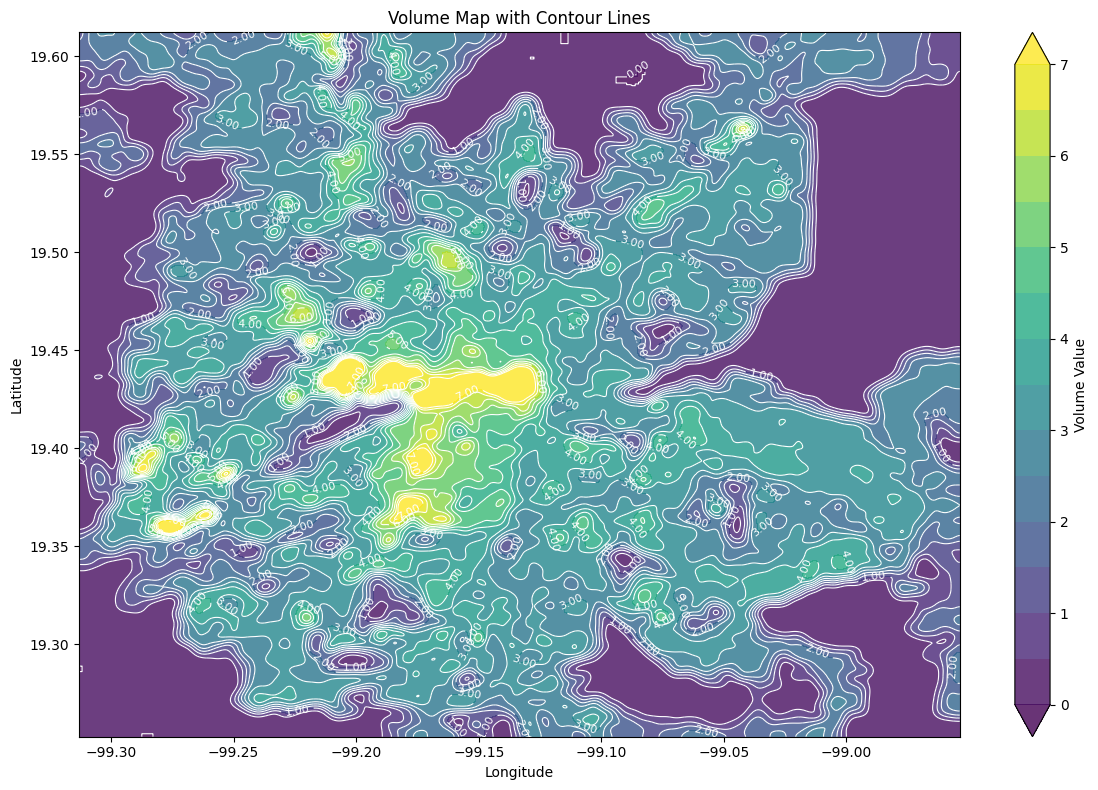

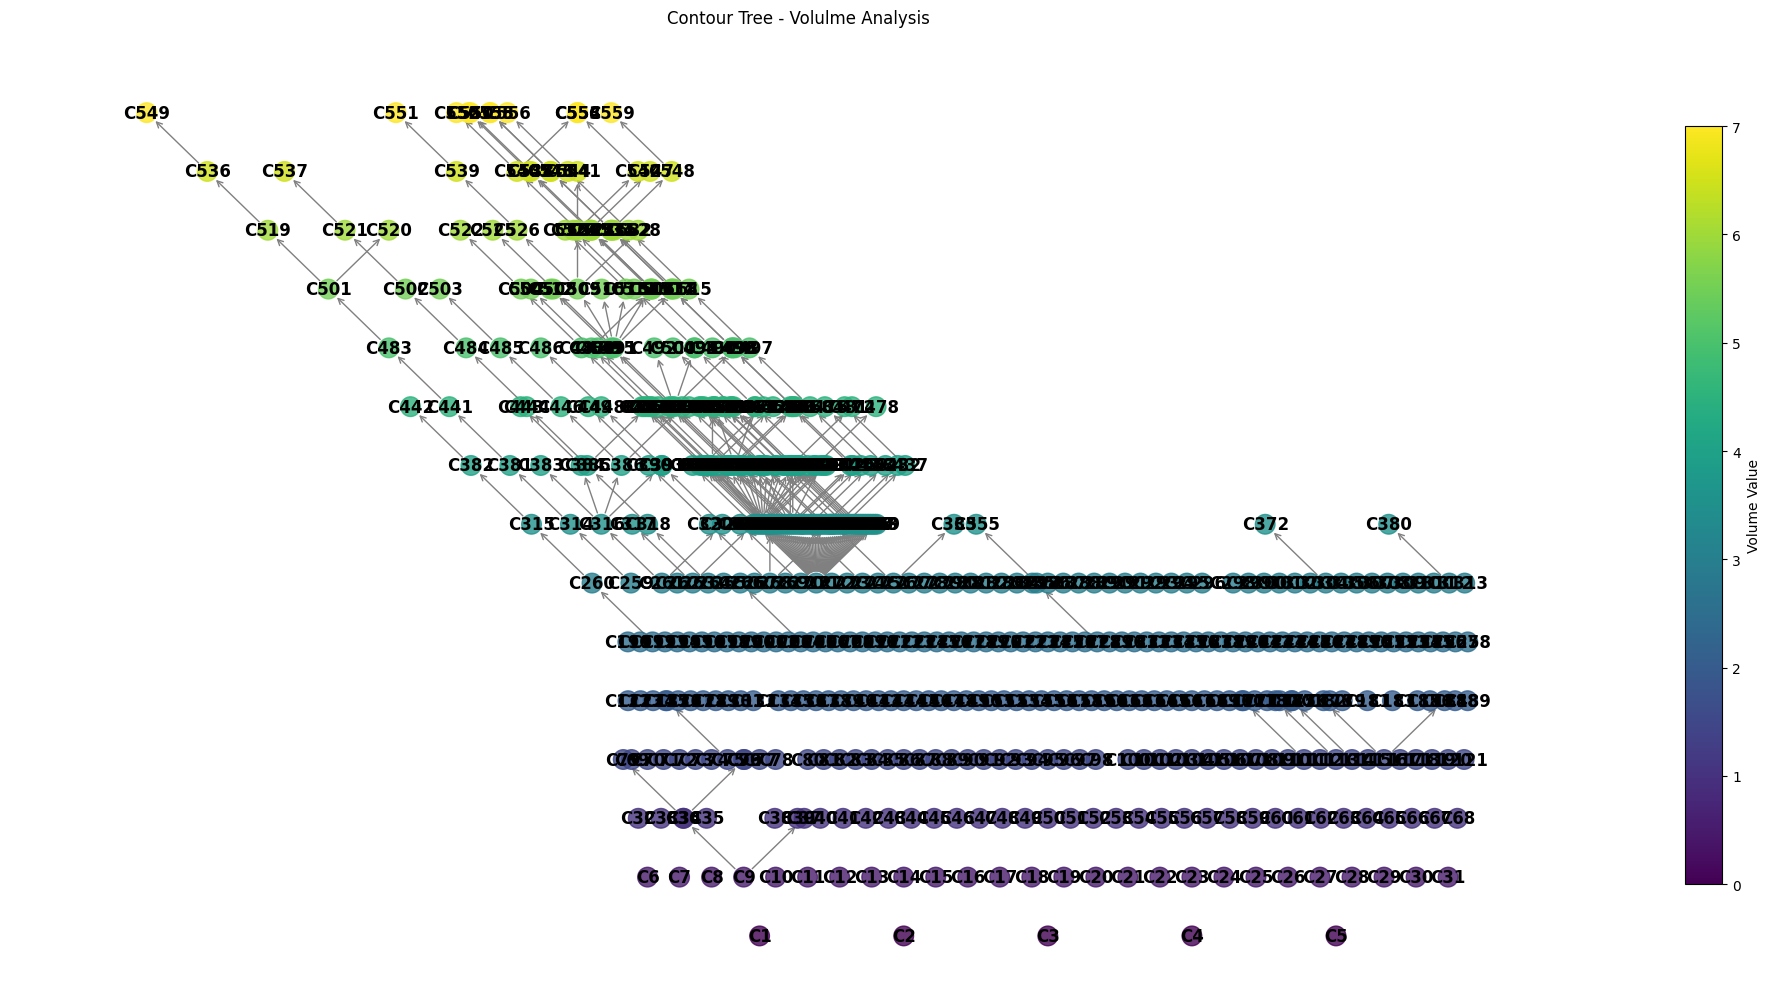

2025-10-24 17:03:49,205 - INFO - Polycentrism index: 14.486


Contour tree: 559 nodes, 259 edges
- Root nodes (no parent): 300
- Leaf nodes (no children): 416
- Branch nodes (multiple children): 36
城市多中心性指标 Polycentrism = 14.486


In [22]:
# Create the analyzer instance
analyzer = TerrainAnalyzer()

# Load TIFF data (or use your own file path)
analyzer.load_tiff("/home/liang/Documents/Research/Urban_Growth/Python_Codes/images/Mexico City_2016.tif")

# Process data
analyzer.process_data(conf_threshold=0, smooth=True, sigma=30)

# Extract contours
analyzer.extract_contours(levels=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7], min_points=5, min_area=10)

# Build hierarchical contour tree
analyzer.build_contour_tree()

# Create visualizations
analyzer.create_contour_map(include_zeros=True)
analyzer.visualize_contour_tree(levels=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7])
analyzer.get_node_information()

poly_index = analyzer.compute_polycentrism()
print(f"城市多中心性指标 Polycentrism = {poly_index:.3f}")

In [16]:
import os
logger.info(f"Current working directory: {os.getcwd()}")

2025-10-24 16:45:50,066 - INFO - Current working directory: /home/liang/Documents/Research/Urban_Growth/Python_Codes/notebooks


2025-06-03 17:02:46,700 - INFO - Loading TIFF data from Yaounde_2023.tif
2025-06-03 17:02:47,151 - INFO - Data loaded successfully. Shape: (4001, 4001)
2025-06-03 17:02:47,156 - INFO - Processing Volume data with confidence threshold: 0.34
2025-06-03 17:02:47,183 - INFO - Applying Gaussian smoothing with sigma=30
2025-06-03 17:02:48,917 - INFO - Extracting contours at 15 levels from 0.00 to 7.00


Extracting contours:   0%|          | 0/15 [00:00<?, ?it/s]

2025-06-03 17:02:49,037 - INFO - Level 1: Kept 8 significant contours
2025-06-03 17:02:49,170 - INFO - Level 2: Kept 17 significant contours
2025-06-03 17:02:49,292 - INFO - Level 3: Kept 11 significant contours
2025-06-03 17:02:49,413 - INFO - Level 4: Kept 15 significant contours
2025-06-03 17:02:49,530 - INFO - Level 5: Kept 10 significant contours
2025-06-03 17:02:49,643 - INFO - Level 6: Kept 10 significant contours
2025-06-03 17:02:49,753 - INFO - Level 7: Kept 3 significant contours
2025-06-03 17:02:49,862 - INFO - Level 8: Kept 1 significant contours
2025-06-03 17:02:49,971 - INFO - Level 9: Kept 0 significant contours
2025-06-03 17:02:50,080 - INFO - Level 10: Kept 0 significant contours
2025-06-03 17:02:50,189 - INFO - Level 11: Kept 0 significant contours
2025-06-03 17:02:50,299 - INFO - Level 12: Kept 0 significant contours
2025-06-03 17:02:50,409 - INFO - Level 13: Kept 0 significant contours
2025-06-03 17:02:50,519 - INFO - Level 14: Kept 0 significant contours
2025-06-03

Processing level 7:   0%|          | 0/1 [00:00<?, ?it/s]

Processing level 6:   0%|          | 0/3 [00:00<?, ?it/s]

Processing level 5:   0%|          | 0/10 [00:00<?, ?it/s]

Processing level 4:   0%|          | 0/10 [00:00<?, ?it/s]

Processing level 3:   0%|          | 0/15 [00:00<?, ?it/s]

Processing level 2:   0%|          | 0/11 [00:00<?, ?it/s]

Processing level 1:   0%|          | 0/17 [00:00<?, ?it/s]

Processing level 0:   0%|          | 0/8 [00:00<?, ?it/s]

2025-06-03 17:02:50,672 - INFO - Built contour tree with 75 nodes and 50 edges


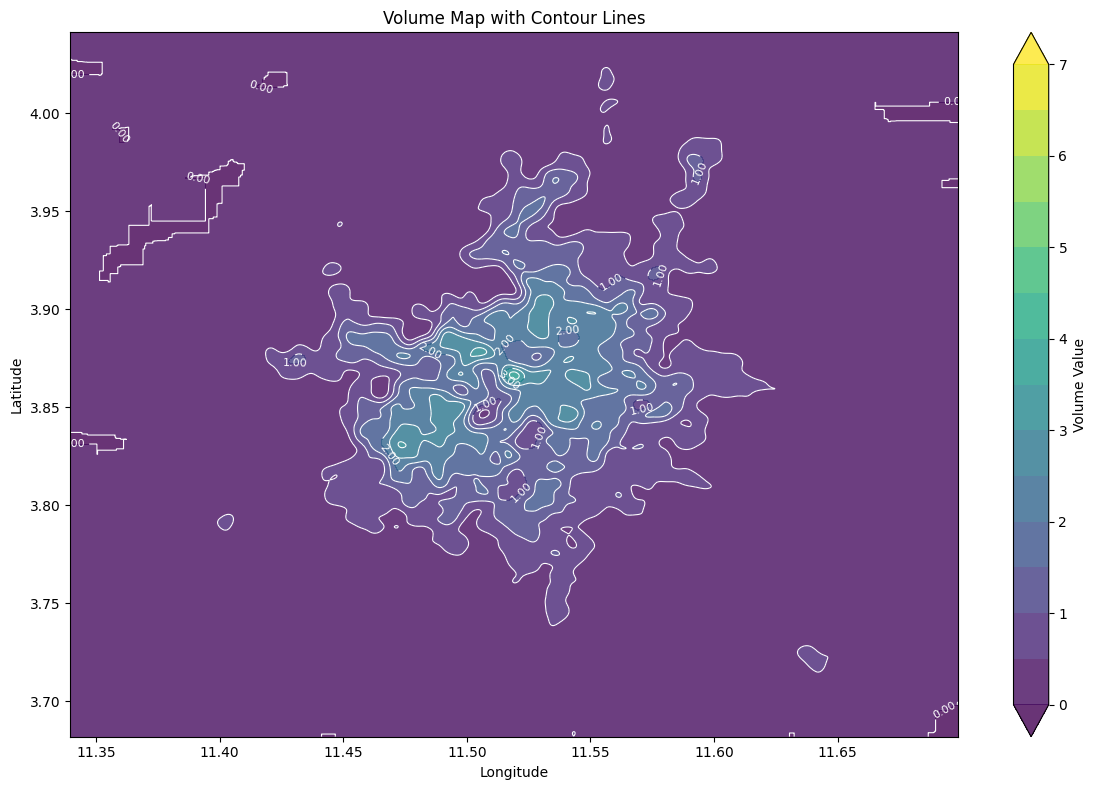

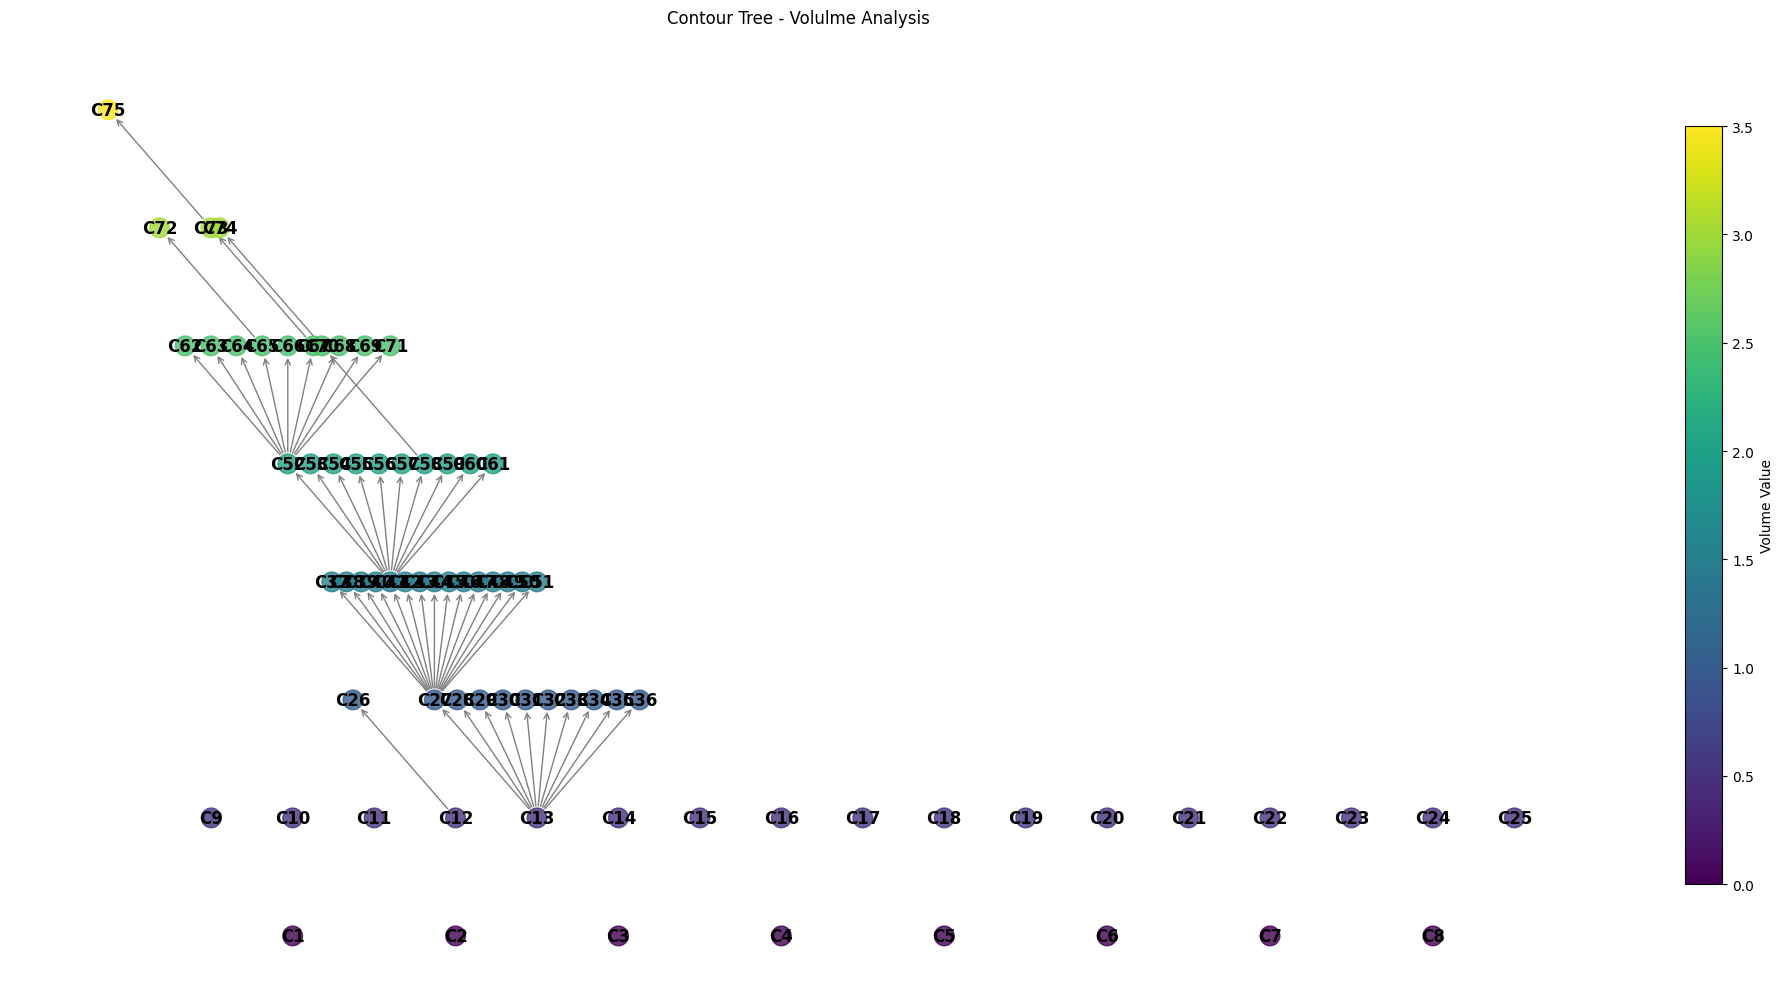

Contour tree: 75 nodes, 50 edges
- Root nodes (no parent): 25
- Leaf nodes (no children): 65
- Branch nodes (multiple children): 4


{'C1': {'node_id': '0_0',
  'value': np.float64(0.0),
  'coordinates': (70.18097997071925, 203.08684546615584),
  'area': 10701.0,
  'perimeter': 464.9705627484773,
  'lat_lon': (4.034856672443861, 11.357677433169307)},
 'C2': {'node_id': '0_1',
  'value': np.float64(0.0),
  'coordinates': (921.2463918463919, 273.18931658931655),
  'area': 9157.5,
  'perimeter': 438.0416305603427,
  'lat_lon': (3.958404165716522, 11.363974845295756)},
 'C3': {'node_id': '0_2',
  'value': np.float64(0.0),
  'coordinates': (3840.0447351728512, 455.34716671952634),
  'area': 31530.0,
  'perimeter': 1021.7989898732235,
  'lat_lon': (3.696204049409232, 11.380338363385187)},
 'C4': {'node_id': '0_3',
  'value': np.float64(0.0),
  'coordinates': (242.15713572854293, 579.9330838323353),
  'area': 3340.0,
  'perimeter': 311.7989898732234,
  'lat_lon': (4.019407791521724, 11.391530106738037)},
 'C5': {'node_id': '0_4',
  'value': np.float64(0.0),
  'coordinates': (457.06214634773664, 1080.5622219952795),
  'area

In [5]:
# Create the analyzer instance
analyzer = TerrainAnalyzer()

# Load TIFF data (or use your own file path)
analyzer.load_tiff("Yaounde_2023.tif")

# Process data
analyzer.process_data(conf_threshold=0.34, smooth=True, sigma=30)

# Extract contours
analyzer.extract_contours(levels=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7], min_points=5, min_area=10)

# Build hierarchical contour tree
analyzer.build_contour_tree()

# Create visualizations
analyzer.create_contour_map(include_zeros=True)
analyzer.visualize_contour_tree()
analyzer.get_node_information()